# GHG emissions of EU27 countries in a given year (in a treemap)

In [1]:
import os
import sys

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../"))


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify

from data_analysis.eurostat_geo import *
from data_analysis.illustrator_strings import *
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_code
from data_analysis.eurostat_population_utils import get_eurostat_population_data


In [3]:
year = 2021

plt.rcParams['svg.fonttype'] = 'none'

### Fetch the data from eurostat

In [4]:
df_emis = get_eurostat_crf_data_for_code(
    "TOTX4_MEMONIA", year).rename(columns={'value': 'emissions'})
df_demo = get_eurostat_population_data(
    year).rename(columns={'value': 'population'})

# Merge the data frames on select only EU27 countries.
df = df_emis.merge(df_demo, on='geo')
df = df.loc[df.index.isin([geo.value for geo in eu27_geo_dict.keys()])]
df['country'] = eu27_geo_dict.values()
df = df.sort_values('emissions', ascending=False)

# Make some more computations.
total_emissions = df['emissions'].sum()
df['em_per_capita'] = (df['emissions'] * 1000000) / df['population']
df['em_per_cent'] = (df['emissions'] * 100) / total_emissions
df['emissions_summary'] = \
    df['emissions'].apply(czech_float) + \
    " (" + df['em_per_cent'].apply(czech_float) + "%)"
df = df.set_index('country')
df


,emissions,population,em_per_capita,em_per_cent,emissions_summary
country,,,,,
Německo,778.65623,83155031.0,9.363910,21.986904,"778,7 (22,0%)"
Francie,423.21805,67656682.0,6.255377,11.950402,"423,2 (12,0%)"
Itálie,422.59122,59236213.0,7.134001,11.932702,"422,6 (11,9%)"
Polsko,402.39063,37840001.0,10.634002,11.362298,"402,4 (11,4%)"
Španělsko,297.16752,47398695.0,6.269530,8.391115,"297,2 (8,4%)"
Nizozemsko,175.00383,17475415.0,10.014288,4.941580,"175,0 (4,9%)"
Česká Republika,119.41326,10494836.0,11.378287,3.371870,"119,4 (3,4%)"
Rumunsko,115.65221,19201662.0,6.023031,3.265670,"115,7 (3,3%)"
Belgie,115.52765,11554767.0,9.998267,3.262152,"115,5 (3,3%)"


### Code for plotting graphs

In [5]:
def _draw_treemap_plot(year, df):
    # Define colors using a colormap.
    cmap = matplotlib.cm.viridis
    mini = min(df['emissions'])
    maxi = max(df['emissions'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in df['emissions']]

    # Make the figure a bit larger to accommodate a complex graph.
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 2.5, 2.5])

    # Produce rectangles using squarify (first normalizing data).
    sizes = df['emissions']
    norm_x = norm_y = 100
    normed = squarify.normalize_sizes(sizes, norm_x, norm_y)
    rects = squarify.squarify(normed, 0, 0, norm_x, norm_y)

    # Pad the rectangles a bit. Watch out, this is imprecise, does not preserve ratios between
    # areas! (This is very much the same code as in squarify, only modified for smaller padding.)
    pad = 0.1
    for rect in rects:
        if rect["dx"] > 2:
            rect["x"] += pad
            rect["dx"] -= 2 * pad
        if rect["dy"] > 2:
            rect["y"] += pad
            rect["dy"] -= 2 * pad
        # Squarify puts the largest square on the bottom left. The resulting graph should have it on
        # the top left, thus flip the y-axis.
        rect["y"] = norm_y - rect["y"] - rect["dy"]

    ax.bar([rect["x"] for rect in rects], [rect["dy"] for rect in rects],
           width=[rect["dx"] for rect in rects], bottom=[rect["y"] for rect in rects],
           color=colors, label=df.index, align="edge")

    # Print the labels of countries and their emission summary
    countries = df.index
    pad_x = 0.5
    pad_y = 1
    for l, r in zip(countries, rects):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x, y + dy - pad_y, l,
                va="top", ha="left", color="white", fontsize=12, fontweight="bold")

    emissions = df["emissions_summary"]
    pad_y = 4
    for l, r in zip(emissions, rects):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x, y + dy - pad_y, l, va="top",
                ha="left", color="white", fontsize=12)

    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)
    plt.title(
        f"Celkové roční emise států EU za rok {year} v milionech tun CO2 ekv.")
    plt.axis("off")

    plt.savefig("output-EU-treemap.svg")
    plt.show()
    plt.clf()


In [6]:
def _draw_barh_plot(year, df):
    fig = plt.figure(figsize=(5,10))
    df_sorted = df.sort_values(by='em_per_capita', ascending=True)
    plt.barh(df_sorted.index, df_sorted['em_per_capita'], color="lightsteelblue")

    # Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
    fake_bar = plt.barh(df_sorted.index, [0] * df_sorted.index.size)
    # Add emission value labels on the left.        
    plt.bar_label(fake_bar, labels=[czech_float(x) for x in df_sorted['em_per_capita']], padding=-30, fontsize=9)
    # Add country name labels on the right.
    plt.bar_label(fake_bar, labels=df_sorted.index, padding=3, fontsize=10)

    plt.title(f'Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU za rok {year}.')
    plt.axis("off")

    plt.savefig("output-EU-bars.svg")

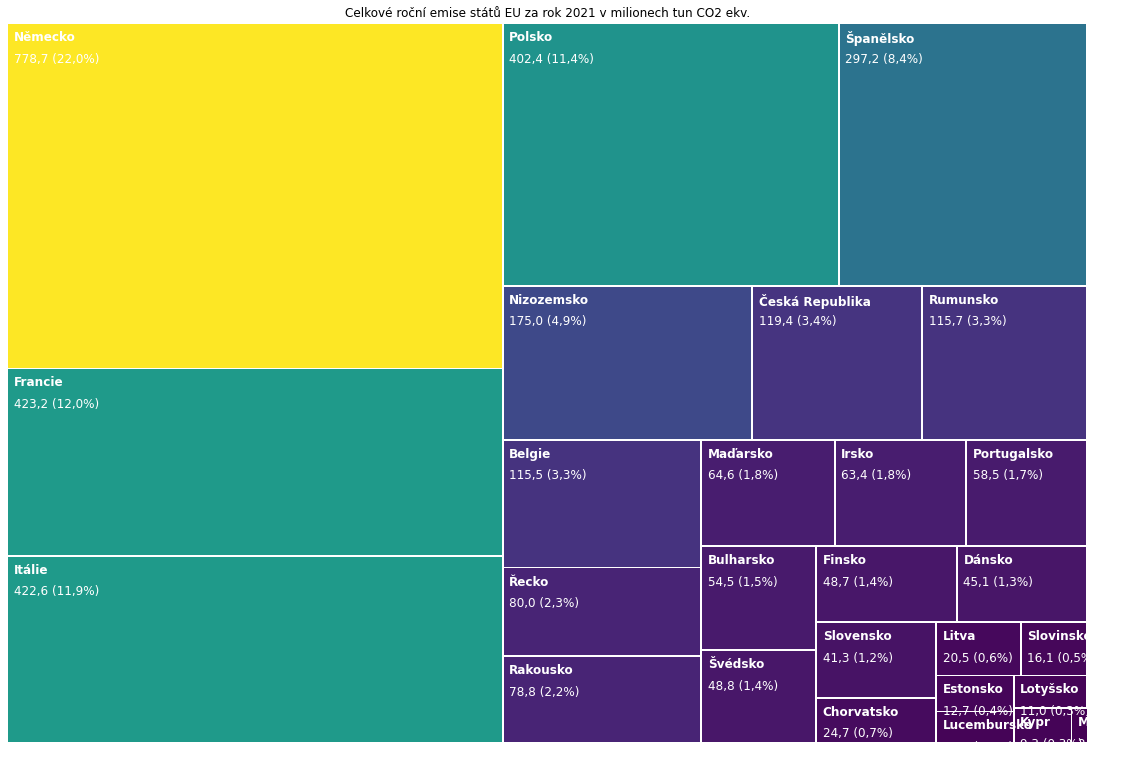

<Figure size 432x288 with 0 Axes>

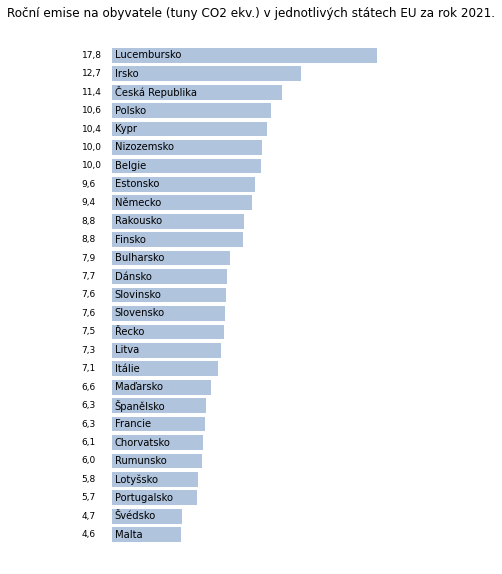

In [7]:
# draw plots
_draw_treemap_plot(year, df)
_draw_barh_plot(year, df)